# Simulation Model - Version 2

### Imports

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import sys

### Class Definitions

In [121]:
class Trait():

    def __init__(self, type, s_causal, s_noncausal, h2, n):
        self.s_causal = s_causal
        self.s_noncausal = s_noncausal
        self.s = s_causal + s_noncausal
        self.h2 = h2
        self.n = n
        self.type = type
    
    def __repr__(self):
        return f"Trait(type='{self.type}', n={self.n})"

    def define_uncorrelated_polygenic_trait(self):
        # compute va and ve from h2
        ve = 1 - self.h2
        va = self.h2

        # simulate genotypes for each person for each SNP
        G = np.zeros((self.n, self.s))
        snp_freqs = []
        for snp in range(self.s):
            freq = np.random.uniform()
            snp_freqs.append(freq)
            s_array = np.array(np.random.binomial(2, freq, size = self.n))
            G[:, snp] = s_array
        self.snp_freqs = snp_freqs

        # scale genotypes
        self.alleles = G.astype(int)
        standardized_G = StandardScaler().fit_transform(G)
        self.standard_alleles = standardized_G

        # choose causal SNPs and effect sizes
        causal_snps = np.random.choice(range(0, self.s), size=self.s_causal, replace=False)
        effect_sizes = list(np.random.normal(loc=0, scale = np.sqrt(va/self.s_causal), size=self.s_causal))
        
        causal_snp_effect = dict(zip(range(0, self.s), [0]*self.s))
        for k in list(causal_snp_effect.keys()):
            if k in causal_snps:
                causal_snp_effect[k] = effect_sizes[0]
                del effect_sizes[0]
        self.causal_snp_effect = causal_snp_effect

        # simulate phenotypes
        phenotypes = []
        genotypes = []
        environments = []
        for i, row in enumerate(self.standard_alleles):
            genotype = np.sum(np.array(row) * np.array(list(causal_snp_effect.values())))
            environment = np.random.normal(loc=0, scale=np.sqrt(ve))
            phenotype = genotype + environment
            phenotypes.append(phenotype)
            genotypes.append(genotype)
            environments.append(environment)

        self.phenotypes = phenotypes
        self.genotypes = genotypes
        self.environment = environments

        return self.genotypes, self.environment, self.phenotypes

    def define_two_correlated_polygenic_traits(self, trait_2, rg, re):
        # simulate genotypes for each person for each SNP
        trait_1_G = np.zeros((self.n, self.s))
        trait_2_G = np.zeros((trait_2.n, trait_2.s))

        assert self.s == trait_2.s
        assert self.s_causal == trait_2.s_causal
        assert self.s_noncausal == trait_2.s_noncausal
        assert self.n == trait_2.n

        snp_freqs = []
        for snp in range(self.s):
            freq = np.random.uniform()
            snp_freqs.append(freq)
            s_array = np.array(np.random.binomial(2, freq, size = self.n))
            trait_1_G[:, snp] = s_array
            trait_2_G[:, snp] = s_array
        self.snp_freqs = snp_freqs
        trait_2.snp_freqs = snp_freqs

        # scale genotypes
        self.alleles = trait_1_G.astype(int)
        standardized_G1 = StandardScaler().fit_transform(trait_1_G)
        self.standard_alleles = standardized_G1

        trait_2.alleles = trait_2_G.astype(int)
        standardized_G2 = StandardScaler().fit_transform(trait_2_G)
        trait_2.standard_alleles = standardized_G2

        # choose causal SNPs
        causal_snps = np.random.choice(range(0, self.s), size=self.s_causal, replace=False)

        # choose effect sizes so rg is true
        effects = np.random.multivariate_normal([0, 0],
            [[1, rg], [rg, 1]], size=self.s_causal)
        trait_1_effect_sizes = effects[:, 0]
        trait_2_effect_sizes = effects[:, 1]

        # normalize so that genetic variance equals h2
        trait_1_denom = max(1e-12, np.var(standardized_G1[:, causal_snps] @ trait_1_effect_sizes))
        trait_2_denom = max(1e-12, np.var(standardized_G2[:, causal_snps] @ trait_2_effect_sizes))
        trait_1_effect_sizes *= np.sqrt(self.h2 / trait_1_denom)
        trait_2_effect_sizes *= np.sqrt(trait_2.h2 / trait_2_denom)
        trait_1_effect_sizes = list(trait_1_effect_sizes)
        trait_2_effect_sizes = list(trait_2_effect_sizes)

        causal_snp_effect_1 = dict(zip(range(0, self.s), [0]*self.s))
        for k in list(causal_snp_effect_1.keys()):
            if k in causal_snps:
                causal_snp_effect_1[k] = trait_1_effect_sizes[0]
                del trait_1_effect_sizes[0]
        self.causal_snp_effect = causal_snp_effect_1

        causal_snp_effect_2 = dict(zip(range(0, trait_2.s), [0]*trait_2.s))
        for k in list(causal_snp_effect_2.keys()):
            if k in causal_snps:
                causal_snp_effect_2[k] = trait_2_effect_sizes[0]
                del trait_2_effect_sizes[0]
        trait_2.causal_snp_effect = causal_snp_effect_2

        # choose environment so re is true
        mean = [0, 0]
        cov_e = [[1-self.h2, re*np.sqrt((1-self.h2)*(1-trait_2.h2))], 
                [re*np.sqrt((1-self.h2)*(1-trait_2.h2)), 1-trait_2.h2]]
        environment = np.random.multivariate_normal(mean, cov_e, size=self.n)
        trait_1_phenotypes_noise = environment[:, 0]
        trait_2_phenotypes_noise = environment[:, 1]

        # simulate phenotypes
        trait_1_phenotypes_causal = []
        for i, row in enumerate(self.standard_alleles):
            phenotype_causal = np.sum(np.array(row) * np.array(list(self.causal_snp_effect.values())))
            trait_1_phenotypes_causal.append(phenotype_causal)
        trait_1_phenotypes = np.array(trait_1_phenotypes_causal) + np.array(trait_1_phenotypes_noise)

        trait_2_phenotypes_causal = []
        for i, row in enumerate(trait_2.standard_alleles):
            phenotype_causal = np.sum(np.array(row) * np.array(list(trait_2.causal_snp_effect.values())))
            trait_2_phenotypes_causal.append(phenotype_causal)
        trait_2_phenotypes = np.array(trait_2_phenotypes_causal) + np.array(trait_2_phenotypes_noise)

        # update objects
        self.phenotypes = trait_1_phenotypes
        self.genotypes = trait_1_phenotypes_causal
        self.environment = trait_1_phenotypes_noise
        self.correlated_trait = trait_2
        self.re = re
        self.rg = rg
        trait_2.phenotypes = trait_2_phenotypes
        trait_2.genotypes = trait_2_phenotypes_causal
        trait_2.environment = trait_2_phenotypes_noise
        trait_2.correlated_trait = self
        trait_2.re = re
        trait_2.rg = rg

        #return self.genotypes, self.environment, self.phenotypes
        return (trait_1_phenotypes,
            trait_2_phenotypes,
            trait_1_phenotypes_causal,
            trait_2_phenotypes_causal,
            trait_1_phenotypes_noise,
            trait_2_phenotypes_noise)

    def define_monogenic_recessive_trait(self):
        assert self.s == 1
        assert self.s_causal == 1
        assert self.h2 == 1

        # compute va and ve from h2
        ve = 1 - self.h2
        va = self.h2

        # simulate genotypes for each person for each SNP
        snp_freqs = [0.5]
        G = np.array(np.random.binomial(2, snp_freqs[0], size = self.n))
        self.snp_freqs = snp_freqs

        # scale genotypes
        self.alleles = G.astype(int)
        standardized_G = StandardScaler().fit_transform(G.reshape(-1, 1))
        self.standard_alleles = standardized_G

        # simulate phenotypes
        phenotypes = []
        phenotypes_causal = []
        phenotypes_noise = []
        for i, val in enumerate(self.alleles):
            phenotype_causal = val
            phenotype = 1 if val == 0 else 0
            phenotypes.append(phenotype)
            phenotypes_causal.append(phenotype_causal)
            phenotypes_noise.append(0)

        self.phenotypes = phenotypes
        self.genotypes = phenotypes_causal
        self.environment = phenotypes_noise

        return self.genotypes, self.environment, self.phenotypes

    @staticmethod
    def get_assortative_pairs(phenotypes, target_corr=0.3, max_tries=1000):
        def safe_corr(x, y):
            if np.std(x) == 0 or np.std(y) == 0:
                return 0.0
            return np.corrcoef(x, y)[0, 1]
        phenotypes = np.array(phenotypes)
        n = len(phenotypes)

        if np.std(phenotypes) == 0:
            p1_idx = np.arange(n // 2)
            p2_idx = np.arange(n // 2, n)
            index_pairs = list(zip(p1_idx, p2_idx))
            final_corr = 0.0
            return index_pairs, final_corr

        sampled_indices = np.random.choice(n, size=n, replace=False)
        phenos_subset = phenotypes[sampled_indices]

        # sort sampled phenotypes and split into two
        sorted_local_indices = np.argsort(phenos_subset)
        sorted_indices = sampled_indices[sorted_local_indices]

        # create initial index pairings (first half with second half)
        p1_idx = sorted_indices[:n // 2].copy()
        p2_idx = sorted_indices[n // 2:].copy()

        # compute initial correlation
        p1_vals = phenotypes[p1_idx]
        p2_vals = phenotypes[p2_idx]
        initial_corr = safe_corr(p1_vals, p2_vals)

        for i in range(max_tries):
            prev_corr = safe_corr(phenotypes[p1_idx], phenotypes[p2_idx])

            # swap one random pair
            pair_idx = np.random.randint(len(p1_idx))
            p1_idx[pair_idx], p2_idx[pair_idx] = p2_idx[pair_idx], p1_idx[pair_idx]

            # compute new correlation
            new_corr = safe_corr(phenotypes[p1_idx], phenotypes[p2_idx])

            # check if we crossed the target correlation
            crossed = (prev_corr > target_corr and new_corr < target_corr) or (prev_corr < target_corr and new_corr > target_corr)
            if crossed:
                if abs(prev_corr - target_corr) < abs(new_corr - target_corr):
                    final_corr = prev_corr
                    # undo last shuffle to return previous state
                    p1_idx[pair_idx], p2_idx[pair_idx] = p2_idx[pair_idx], p1_idx[pair_idx]
                else:
                    final_corr = new_corr

                # return index-based pairs
                index_pairs = list(zip(p1_idx, p2_idx))
                return index_pairs, final_corr

        # if no crossing occurred after max_tries (not likely)
        final_corr = safe_corr(phenotypes[p1_idx], phenotypes[p2_idx])
        index_pairs = list(zip(p1_idx, p2_idx))
        return index_pairs, final_corr

    def create_trait_offspring(self, offspring_trait, fitness, method, target_corr = 0.5):
        if self.type != "monogenic_recessive":
            offspring_trait.causal_snp_effect = self.causal_snp_effect
        offspring_trait.snp_freqs = self.snp_freqs # might have to edit this if I want to use allele freqs in graph
        if self.type == "correlated_polygenic":
            trait_2 = self.correlated_trait
            offspring_trait_2 = Trait("correlated_polygenic", trait_2.s_causal, trait_2.s_noncausal, trait_2.h2, offspring_trait.n)
            offspring_trait.correlated_trait = offspring_trait_2
            offspring_trait_2.correlated_trait = offspring_trait
            offspring_trait_2.causal_snp_effect = trait_2.causal_snp_effect
            offspring_trait_2.snp_freqs = trait_2.snp_freqs
            offspring_trait_2_alleles = []
        
        if method == "assortative":
            corr = 0
            while abs(corr - target_corr) > 0.05:
                pairs, corr = Trait.get_assortative_pairs(self.phenotypes, target_corr=target_corr, max_tries=1000)
        offspring_alleles = []

        def punnett_single_offspring(a, b):
            pair = tuple(sorted((a, b)))
            if pair == (0, 0):
                return 0
            elif pair == (0, 1):
                return np.random.choice([0, 1], p=[0.50, 0.50])
            elif pair == (0, 2):
                return 1
            elif pair == (1, 1):
                return np.random.choice([0, 1, 2], p=[0.25, 0.5, 0.25])
            elif pair == (1, 2):
                return np.random.choice([1, 2], p=[0.5, 0.5])
            elif pair == (2, 2):
                return 2

        for n in range(0, offspring_trait.n):
            if method == "random":
                par1, par2 = np.random.choice(range(0, self.n), p = fitness, size = 2, replace=False)
            elif method == "assortative":
                pair = pairs[n % len(pairs)]
                par1 = pair[0]
                par2 = pair[1]
            else:
                print("Method does not match expected options.")
                sys.exit()

            par1_allele = self.alleles[par1]
            par2_allele = self.alleles[par2]
            par1_allele = np.atleast_1d(par1_allele)
            par2_allele = np.atleast_1d(par2_allele)
            
            offspring_allele = [
                    punnett_single_offspring(par1_allele[i], par2_allele[i])
                    for i in range(len(par1_allele))
                ]
            offspring_alleles.append(offspring_allele)

            if self.type == "correlated_polygenic":
                offspring_trait_2_alleles.append(offspring_allele)
                
        offspring_trait.alleles = np.asarray(offspring_alleles, dtype=np.float64)
        offspring_trait.standard_alleles = StandardScaler().fit_transform(offspring_trait.alleles)
        if self.type == "correlated_polygenic":
            offspring_trait_2.alleles = np.asarray(offspring_trait_2_alleles, dtype=np.float64)
            offspring_trait_2.standard_alleles = StandardScaler().fit_transform(offspring_trait_2.alleles)

        if self.type == "monogenic_recessive":
            offspring_trait.environment = [0]*offspring_trait.n
            offspring_trait.genotypes = [int(x[0]) for x in offspring_trait.alleles]
            offspring_trait.phenotypes = (np.array(offspring_trait.genotypes) == 0).astype(int)
        elif self.type == "uncorrelated_polygenic":
            offspring_trait.causal_snp_effect = self.causal_snp_effect
            ve = 1 - offspring_trait.h2
            phenotypes = []
            genotypes = []
            environments = []
            for i, row in enumerate(offspring_trait.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(self.causal_snp_effect.values())))
                environment = np.random.normal(loc=0, scale=np.sqrt(ve))
                phenotype = genotype + environment
                phenotypes.append(phenotype)
                genotypes.append(genotype)
                environments.append(environment)
            offspring_trait.phenotypes = phenotypes
            offspring_trait.genotypes = genotypes
            offspring_trait.environment = environments
        elif self.type == "correlated_polygenic":
            trait_2 = self.correlated_trait
            offspring_trait.correlated_trait = offspring_trait_2
            re = self.re
            offspring_trait_2.re = re
            offspring_trait.re = re
            # choose environment so re is true
            mean = [0, 0]
            cov_e = [[1-offspring_trait.h2, re*np.sqrt((1-offspring_trait.h2)*(1-trait_2.h2))], 
                    [re*np.sqrt((1-offspring_trait.h2)*(1-trait_2.h2)), 1-trait_2.h2]]
            environment = np.random.multivariate_normal(mean, cov_e, size=offspring_trait.n)
            offspring_trait.environment = environment[:, 0]
            offspring_trait_2.environment = environment[:, 1]
            # simulate phenotypes
            offspring_trait.genotypes = []
            for i, row in enumerate(offspring_trait.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(offspring_trait.causal_snp_effect.values())))
                offspring_trait.genotypes.append(genotype)
            offspring_trait.phenotypes = np.array(offspring_trait.genotypes) + np.array(offspring_trait.environment)

            offspring_trait_2.genotypes = []
            for i, row in enumerate(offspring_trait_2.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(offspring_trait_2.causal_snp_effect.values())))
                offspring_trait_2.genotypes.append(genotype)
            offspring_trait_2.phenotypes = np.array(offspring_trait_2.genotypes) + np.array(offspring_trait_2.environment)
        else:
            print("Trait type does not match expected values.")
            sys.exit()

    def create_trait_offspring_ivf(self, offspring_trait, fitness, ivf_n):
        if self.type != "monogenic_recessive":
            offspring_trait.causal_snp_effect = self.causal_snp_effect
        offspring_trait.snp_freqs = self.snp_freqs # might have to edit this if I want to use allele freqs in graph
        if self.type == "correlated_polygenic":
            trait_2 = self.correlated_trait
            offspring_trait_2 = Trait("correlated_polygenic", trait_2.s_causal, trait_2.s_noncausal, trait_2.h2, offspring_trait.n)
            offspring_trait.correlated_trait = offspring_trait_2
            offspring_trait_2.correlated_trait = offspring_trait
            offspring_trait_2.causal_snp_effect = trait_2.causal_snp_effect
            offspring_trait_2.snp_freqs = trait_2.snp_freqs
            offspring_trait_2_alleles = []
        
        def punnett_single_offspring(a, b):
            pair = tuple(sorted((a, b)))
            if pair == (0, 0):
                return 0
            elif pair == (0, 1):
                return np.random.choice([0, 1], p=[0.50, 0.50])
            elif pair == (0, 2):
                return 1
            elif pair == (1, 1):
                return np.random.choice([0, 1, 2], p=[0.25, 0.5, 0.25])
            elif pair == (1, 2):
                return np.random.choice([1, 2], p=[0.5, 0.5])
            elif pair == (2, 2):
                return 2

        offspring_alleles = []
        for n in range(0, offspring_trait.n-ivf_n):
            par1, par2 = np.random.choice(range(0, self.n), p = fitness, size = 2, replace=False)
            par1_allele = self.alleles[par1]
            par2_allele = self.alleles[par2]
            par1_allele = np.atleast_1d(par1_allele)
            par2_allele = np.atleast_1d(par2_allele)
            
            offspring_allele = [
                    punnett_single_offspring(par1_allele[i], par2_allele[i])
                    for i in range(len(par1_allele))
                ]
            offspring_alleles.append(offspring_allele)
            if self.type == "correlated_polygenic":
                offspring_trait_2_alleles.append(offspring_allele)
        for n in range(offspring_trait.n-ivf_n, offspring_trait.n):
            par1, par2 = np.random.choice(range(0, self.n), p = fitness, size = 2, replace=False)
            par1_allele = self.alleles[par1]
            par2_allele = self.alleles[par2]
            par1_allele = np.atleast_1d(par1_allele)
            par2_allele = np.atleast_1d(par2_allele)

            offspring_allele_ivf = [[
                    punnett_single_offspring(par1_allele[i], par2_allele[i])
                    for i in range(len(par1_allele))
                ] for j in range(0,7)]
            max_score = 0
            best = None
            for choice in offspring_allele_ivf:
                if self.type == "monogenic_recessive":
                    score = sum(np.array(choice) == 0)
                else:
                    effect_sizes = np.array(list(offspring_trait.causal_snp_effect.values()))
                    score = sum(np.array(choice)*effect_sizes)
                if score >= max_score:
                    max_score = score
                    best = choice
            offspring_alleles.append(best)
            if self.type == "correlated_polygenic":
                offspring_trait_2_alleles.append(best)

        offspring_trait.alleles = np.asarray(offspring_alleles, dtype=np.float64)
        offspring_trait.standard_alleles = StandardScaler().fit_transform(offspring_trait.alleles)
        if self.type == "correlated_polygenic":
            offspring_trait_2.alleles = np.asarray(offspring_trait_2_alleles, dtype=np.float64)
            offspring_trait_2.standard_alleles = StandardScaler().fit_transform(offspring_trait_2.alleles)
            
        if self.type == "monogenic_recessive":
            offspring_trait.environment = [0]*offspring_trait.n
            offspring_trait.genotypes = [int(x[0]) for x in offspring_trait.alleles]
            offspring_trait.phenotypes = (np.array(offspring_trait.genotypes) == 0).astype(int)
        elif self.type == "uncorrelated_polygenic":
            offspring_trait.causal_snp_effect = self.causal_snp_effect
            ve = 1 - offspring_trait.h2
            phenotypes = []
            genotypes = []
            environments = []
            for i, row in enumerate(offspring_trait.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(self.causal_snp_effect.values())))
                environment = np.random.normal(loc=0, scale=np.sqrt(ve))
                phenotype = genotype + environment
                phenotypes.append(phenotype)
                genotypes.append(genotype)
                environments.append(environment)
            offspring_trait.phenotypes = phenotypes
            offspring_trait.genotypes = genotypes
            offspring_trait.environment = environments
        elif self.type == "correlated_polygenic":
            trait_2 = self.correlated_trait
            offspring_trait.correlated_trait = offspring_trait_2
            re = self.re
            offspring_trait_2.re = re
            offspring_trait.re = re
            # choose environment so re is true
            mean = [0, 0]
            cov_e = [[1-offspring_trait.h2, re*np.sqrt((1-offspring_trait.h2)*(1-trait_2.h2))], 
                    [re*np.sqrt((1-offspring_trait.h2)*(1-trait_2.h2)), 1-trait_2.h2]]
            environment = np.random.multivariate_normal(mean, cov_e, size=offspring_trait.n)
            offspring_trait.environment = environment[:, 0]
            offspring_trait_2.environment = environment[:, 1]
            # simulate phenotypes
            offspring_trait.genotypes = []
            for i, row in enumerate(offspring_trait.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(offspring_trait.causal_snp_effect.values())))
                offspring_trait.genotypes.append(genotype)
            offspring_trait.phenotypes = np.array(offspring_trait.genotypes) + np.array(offspring_trait.environment)

            offspring_trait_2.genotypes = []
            for i, row in enumerate(offspring_trait_2.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(offspring_trait_2.causal_snp_effect.values())))
                offspring_trait_2.genotypes.append(genotype)
            offspring_trait_2.phenotypes = np.array(offspring_trait_2.genotypes) + np.array(offspring_trait_2.environment)
        else:
            print("Trait type does not match expected values.")
            sys.exit()
    
    def create_trait_offspring_gene_editing(self, offspring_trait, fitness, edit_n):
        if self.type != "monogenic_recessive":
            offspring_trait.causal_snp_effect = self.causal_snp_effect
        offspring_trait.snp_freqs = self.snp_freqs # might have to edit this if I want to use allele freqs in graph
        if self.type == "correlated_polygenic":
            trait_2 = self.correlated_trait
            offspring_trait_2 = Trait("correlated_polygenic", trait_2.s_causal, trait_2.s_noncausal, trait_2.h2, offspring_trait.n)
            offspring_trait.correlated_trait = offspring_trait_2
            offspring_trait_2.correlated_trait = offspring_trait
            offspring_trait_2.causal_snp_effect = trait_2.causal_snp_effect
            offspring_trait_2.snp_freqs = trait_2.snp_freqs
            offspring_trait_2_alleles = []
        
        def punnett_single_offspring(a, b):
            pair = tuple(sorted((a, b)))
            if pair == (0, 0):
                return 0
            elif pair == (0, 1):
                return np.random.choice([0, 1], p=[0.50, 0.50])
            elif pair == (0, 2):
                return 1
            elif pair == (1, 1):
                return np.random.choice([0, 1, 2], p=[0.25, 0.5, 0.25])
            elif pair == (1, 2):
                return np.random.choice([1, 2], p=[0.5, 0.5])
            elif pair == (2, 2):
                return 2

        offspring_alleles = []
        for n in range(0, offspring_trait.n-edit_n):
            par1, par2 = np.random.choice(range(0, self.n), p = fitness, size = 2, replace=False)
            par1_allele = self.alleles[par1]
            par2_allele = self.alleles[par2]
            par1_allele = np.atleast_1d(par1_allele)
            par2_allele = np.atleast_1d(par2_allele)
            
            offspring_allele = [
                    punnett_single_offspring(par1_allele[i], par2_allele[i])
                    for i in range(len(par1_allele))
                ]
            offspring_alleles.append(offspring_allele)
            if self.type == "correlated_polygenic":
                offspring_trait_2_alleles.append(offspring_allele)
        for n in range(offspring_trait.n-edit_n, offspring_trait.n):
            par1, par2 = np.random.choice(range(0, self.n), p = fitness, size = 2, replace=False)
            par1_allele = self.alleles[par1]
            par2_allele = self.alleles[par2]
            par1_allele = np.atleast_1d(par1_allele)
            par2_allele = np.atleast_1d(par2_allele)

            if self.type == "monogenic_recessive":
                best = [0]*len(par1_allele)
            else:
                best = []
                for x in offspring_trait.causal_snp_effect:
                    if x > 0:
                        best.append(2)
                    elif x <= 0:
                        best.append(0)
            offspring_alleles.append(best)
            if self.type == "correlated_polygenic":
                offspring_trait_2_alleles.append(best)

        offspring_trait.alleles = np.asarray(offspring_alleles, dtype=np.float64)
        offspring_trait.standard_alleles = StandardScaler().fit_transform(offspring_trait.alleles)
        if self.type == "correlated_polygenic":
            offspring_trait_2.alleles = np.asarray(offspring_trait_2_alleles, dtype=np.float64)
            offspring_trait_2.standard_alleles = StandardScaler().fit_transform(offspring_trait_2.alleles)
            
        if self.type == "monogenic_recessive":
            offspring_trait.environment = [0]*offspring_trait.n
            offspring_trait.genotypes = [int(x[0]) for x in offspring_trait.alleles]
            offspring_trait.phenotypes = (np.array(offspring_trait.genotypes) == 0).astype(int)
        elif self.type == "uncorrelated_polygenic":
            offspring_trait.causal_snp_effect = self.causal_snp_effect
            ve = 1 - offspring_trait.h2
            phenotypes = []
            genotypes = []
            environments = []
            for i, row in enumerate(offspring_trait.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(self.causal_snp_effect.values())))
                environment = np.random.normal(loc=0, scale=np.sqrt(ve))
                phenotype = genotype + environment
                phenotypes.append(phenotype)
                genotypes.append(genotype)
                environments.append(environment)
            offspring_trait.phenotypes = phenotypes
            offspring_trait.genotypes = genotypes
            offspring_trait.environment = environments
        elif self.type == "correlated_polygenic":
            trait_2 = self.correlated_trait
            offspring_trait.correlated_trait = offspring_trait_2
            re = self.re
            offspring_trait_2.re = re
            offspring_trait.re = re
            # choose environment so re is true
            mean = [0, 0]
            cov_e = [[1-offspring_trait.h2, re*np.sqrt((1-offspring_trait.h2)*(1-trait_2.h2))], 
                    [re*np.sqrt((1-offspring_trait.h2)*(1-trait_2.h2)), 1-trait_2.h2]]
            environment = np.random.multivariate_normal(mean, cov_e, size=offspring_trait.n)
            offspring_trait.environment = environment[:, 0]
            offspring_trait_2.environment = environment[:, 1]
            # simulate phenotypes
            offspring_trait.genotypes = []
            for i, row in enumerate(offspring_trait.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(offspring_trait.causal_snp_effect.values())))
                offspring_trait.genotypes.append(genotype)
            offspring_trait.phenotypes = np.array(offspring_trait.genotypes) + np.array(offspring_trait.environment)

            offspring_trait_2.genotypes = []
            for i, row in enumerate(offspring_trait_2.standard_alleles):
                genotype = np.sum(np.array(row) * np.array(list(offspring_trait_2.causal_snp_effect.values())))
                offspring_trait_2.genotypes.append(genotype)
            offspring_trait_2.phenotypes = np.array(offspring_trait_2.genotypes) + np.array(offspring_trait_2.environment)
        else:
            print("Trait type does not match expected values.")
            sys.exit()


In [ ]:
class Generation():

    def __init__(self, n):
        self.n = n
        self.traits = []
    
    def __repr__(self):
        return f"Generation(n={self.n})"

    def add_trait(self, trait):
        assert self.n == trait.n
        self.traits.append(trait)
    
    def calculate_fitness(self, fitness_func):
        individual_fitness = []
        for i in range(self.n):
            phenotypes_i = [trait.phenotypes[i] for trait in self.traits]
            fitness_i = fitness_func(phenotypes_i)
            individual_fitness.append(fitness_i)
        def squish(x):
            x = np.array(x)
            e = np.exp(x - np.max(x))
            return e / np.sum(e)
        self.fitness = squish(individual_fitness)
    
    def create_offspring_random_mating(self, new_n):
        assert self.fitness.all() != None
        offspring = Generation(new_n)
        processed = set()
        for trait in self.traits:
            if id(trait) in processed:
                continue
            offspring_trait = Trait(
                trait.type, trait.s_causal, trait.s_noncausal, trait.h2, new_n
            )
            trait.create_trait_offspring(offspring_trait, self.fitness, "random")
            offspring.add_trait(offspring_trait)

            if hasattr(offspring_trait, "correlated_trait") and (
                offspring_trait.correlated_trait is not None
            ):
                offspring.add_trait(offspring_trait.correlated_trait)
                processed.add(id(trait))
                processed.add(id(trait.correlated_trait))
        return offspring

    def create_offspring_assortative_mating(self, new_n):
        assert self.fitness.all() != None
        offspring = Generation(new_n)
        processed = set()
        for trait in self.traits:
            if id(trait) in processed:
                continue
            offspring_trait = Trait(
                trait.type, trait.s_causal, trait.s_noncausal, trait.h2, new_n
            )
            trait.create_trait_offspring(offspring_trait, self.fitness, "assortative")
            offspring.add_trait(offspring_trait)

            if hasattr(offspring_trait, "correlated_trait") and (
                offspring_trait.correlated_trait is not None
            ):
                offspring.add_trait(offspring_trait.correlated_trait)
                processed.add(id(trait))
                processed.add(id(trait.correlated_trait))
        return offspring
    
    def create_offspring_ivf(self, new_n, ivf_n):
        assert self.fitness.all() != None
        offspring = Generation(new_n)
        processed = set()
        for trait in self.traits:
            if id(trait) in processed:
                continue
            offspring_trait = Trait(
                trait.type, trait.s_causal, trait.s_noncausal, trait.h2, new_n
            )
            trait.create_trait_offspring_ivf(offspring_trait, self.fitness, ivf_n=ivf_n)
            offspring.add_trait(offspring_trait)

            if hasattr(offspring_trait, "correlated_trait") and (
                offspring_trait.correlated_trait is not None
            ):
                offspring.add_trait(offspring_trait.correlated_trait)
                processed.add(id(trait))
                processed.add(id(trait.correlated_trait))
        return offspring
    
    def create_offspring_gene_editing(self, new_n, edit_n):
        assert self.fitness.all() != None
        offspring = Generation(new_n)
        processed = set()
        for trait in self.traits:
            if id(trait) in processed:
                continue
            offspring_trait = Trait(
                trait.type, trait.s_causal, trait.s_noncausal, trait.h2, new_n
            )
            trait.create_trait_offspring_gene_editing(offspring_trait, self.fitness, edit_n=edit_n)
            offspring.add_trait(offspring_trait)

            if hasattr(offspring_trait, "correlated_trait") and (
                offspring_trait.correlated_trait is not None
            ):
                offspring.add_trait(offspring_trait.correlated_trait)
                processed.add(id(trait))
                processed.add(id(trait.correlated_trait))
        return offspring
    

### Variables

In [123]:
def linear_w_from_p(phenotypes):
    w = 1 + sum(phenotypes)
    return w
def no_fitness(phenotypes):
    w = 1
    return w
pop_size = [5, 3, 3]
trait_dict = {0:["monogenic_recessive", 1, 0, 1], 1:["uncorrelated_polygenic", 2, 2, 0.5], 
                 2:["correlated_polygenic", 2, 1, 0.2, 0.1, 0.1], 3:["correlated_polygenic", 2, 1, 0.8, 0.1, 0.1]}
# trait_dict = {0:["correlated_polygenic", 30, 10, 0.2, 0.3, 0.8], 1:["correlated_polygenic", 30, 10, 0.8, 0.3, 0.8]}
# trait_dict = {0:["monogenic_recessive", 1, 0, 1], 1:["monogenic_recessive", 1, 0, 1]}
# trait_dict = {0:["uncorrelated_polygenic", 5, 2, 0.9], 1:["uncorrelated_polygenic", 20, 0, 0.1]}
mating = "ivf" # random, assortative, ivf, gene_editing
fitness_func = no_fitness # linear_positive, no_fitness, random
ivf_size = [5, 1, 1]
edit_size = [0, 2, 2]
num_gen = len(pop_size)
num_traits = len(trait_dict)

### System

In [136]:
generations = []
gen1 = Generation(pop_size[0])
i = 0
while i < num_traits:
    info = trait_dict[i]
    trait = Trait(info[0], info[1], info[2], info[3], pop_size[0])
    if trait.type == "monogenic_recessive":
        trait.define_monogenic_recessive_trait()
        gen1.add_trait(trait)
        i += 1
    elif trait.type == "uncorrelated_polygenic":
        trait.define_uncorrelated_polygenic_trait()
        gen1.add_trait(trait)
        i += 1
    elif trait.type == "correlated_polygenic":
        trait_2_info = trait_dict[i+1]
        trait_2 = Trait(trait_2_info[0], trait_2_info[1], trait_2_info[2], trait_2_info[3], pop_size[0])
        trait.define_two_correlated_polygenic_traits(trait_2, info[4], info[5])
        gen1.add_trait(trait)
        gen1.add_trait(trait_2)
        i += 2
    else:
        print("Trait type does not match expected value.")
        sys.exit()
gen1.calculate_fitness(fitness_func)
generations.append(gen1)

In [137]:
for g in range(1, num_gen):
    print(g)
    if mating == "random":
        nextgen = generations[-1].create_offspring_random_mating(pop_size[g])
    elif mating == "assortative":
        nextgen = generations[-1].create_offspring_assortative_mating(pop_size[g])
    elif mating == "ivf":
        nextgen = generations[-1].create_offspring_ivf(pop_size[g], ivf_size[g])
    elif mating == "gene_editing":
        nextgen = generations[-1].create_offspring_gene_editing(pop_size[g], edit_size[g])
    nextgen.calculate_fitness(fitness_func)
    generations.append(nextgen)

1
2


### Testing Functions

In [424]:
def compute_h2(genotypes, phenotypes):
    """Estimate narrow-sense heritability as Var(G) / Var(P)."""
    return np.var(genotypes) / np.var(phenotypes)

def compute_rg(trait1_geno, trait2_geno):
    """Compute genetic correlation."""
    return np.corrcoef(trait1_geno, trait2_geno)[0,1]

def compute_re(trait1_env, trait2_env):
    return np.corrcoef(trait1_env, trait2_env)[0,1]

In [425]:
def compute_trait_stats(trait):
    """Return h2, genetic variance, environmental variance."""
    
    P = np.array(trait.phenotypes, dtype=float)
    E = np.array(trait.environment, dtype=float)

    if trait.type == "monogenic_recessive":
        G_effect = P.copy()
    else:
        G_effect = np.array(trait.genotypes, dtype=float)
    
    var_G = np.var(G_effect)
    var_E = np.var(E)
    var_P = np.var(P)

    h2 = var_G / var_P if var_P > 0 else 0.0

    return h2, var_G, var_E


def compute_rg_re(trait1, trait2):
    """Return genetic correlation and environmental correlation."""
    G1 = np.array(trait1.genotypes, dtype=float)
    G2 = np.array(trait2.genotypes, dtype=float)
    E1 = np.array(trait1.environment, dtype=float)
    E2 = np.array(trait2.environment, dtype=float)

    # handle zero variance cases
    if np.std(G1) == 0 or np.std(G2) == 0:
        rg = 0.0
    else:
        rg = np.corrcoef(G1, G2)[0,1]

    if np.std(E1) == 0 or np.std(E2) == 0:
        re = 0.0
    else:
        re = np.corrcoef(E1, E2)[0,1]

    return rg, re


In [436]:
print("=== Trait stability statistics ===")

for g_idx, gen in enumerate(generations):
    print(f"\nGeneration {g_idx}")

    # h2 for each trait
    for t_idx, trait in enumerate(gen.traits):
        h2, varG, varE = compute_trait_stats(trait)
        print(f"  Trait {t_idx}: h2={h2:.3f}, VarG={varG:.3f}, VarE={varE:.3f}")

    # correlations between trait 0 and 1 if they exist
    if len(gen.traits) >= 2:
        rg, re = compute_rg_re(gen.traits[0], gen.traits[1])
        print(f"  r_g(0,1) = {rg:.3f}")
        print(f"  r_e(0,1) = {re:.3f}")

=== Trait stability statistics ===

Generation 0
  Trait 0: h2=1.000, VarG=0.175, VarE=0.000
  Trait 1: h2=0.472, VarG=0.412, VarE=0.506
  Trait 2: h2=0.202, VarG=0.200, VarE=0.802
  Trait 3: h2=0.771, VarG=0.800, VarE=0.195
  r_g(0,1) = -0.041
  r_e(0,1) = 0.000

Generation 1
  Trait 0: h2=1.000, VarG=0.186, VarE=0.000
  Trait 1: h2=0.440, VarG=0.396, VarE=0.485
  Trait 2: h2=0.205, VarG=0.208, VarE=0.845
  Trait 3: h2=0.790, VarG=0.838, VarE=0.202
  r_g(0,1) = -0.013
  r_e(0,1) = 0.000

Generation 2
  Trait 0: h2=1.000, VarG=0.177, VarE=0.000
  Trait 1: h2=0.466, VarG=0.400, VarE=0.487
  Trait 2: h2=0.213, VarG=0.198, VarE=0.771
  Trait 3: h2=0.809, VarG=0.789, VarE=0.213
  r_g(0,1) = -0.056
  r_e(0,1) = 0.000

Generation 3
  Trait 0: h2=1.000, VarG=0.180, VarE=0.000
  Trait 1: h2=0.457, VarG=0.424, VarE=0.487
  Trait 2: h2=0.199, VarG=0.203, VarE=0.759
  Trait 3: h2=0.795, VarG=0.811, VarE=0.188
  r_g(0,1) = -0.055
  r_e(0,1) = 0.000

Generation 4
  Trait 0: h2=1.000, VarG=0.176, Va

In [427]:
import numpy as np
import matplotlib.pyplot as plt

def summarize_generations(generations):
    """
    Summarize key metrics for a list of Generation objects.
    Assumes each Generation has 'traits' (list of Trait objects),
    each Trait has attributes: genotypes, phenotypes, environment, alleles.
    """
    num_gens = len(generations)
    num_traits = len(generations[0].traits)
    
    # Initialize storage
    h2_matrix = np.zeros((num_gens, num_traits))
    varG_matrix = np.zeros((num_gens, num_traits))
    varE_matrix = np.zeros((num_gens, num_traits))
    meanP_matrix = np.zeros((num_gens, num_traits))
    meanG_matrix = np.zeros((num_gens, num_traits))
    
    allele_freqs = {t: [] for t in range(num_traits)}  # store allele frequencies over gens
    
    for g_idx, gen in enumerate(generations):
        for t_idx, trait in enumerate(gen.traits):
            G = np.array(trait.genotypes, dtype=float)
            P = np.array(trait.phenotypes, dtype=float)
            E = np.array(trait.environment, dtype=float)
            
            varG = np.var(G)
            varE = np.var(E)
            varP = np.var(P)
            h2 = varG / varP if varP > 0 else 0.0
            
            h2_matrix[g_idx, t_idx] = h2
            varG_matrix[g_idx, t_idx] = varG
            varE_matrix[g_idx, t_idx] = varE
            meanP_matrix[g_idx, t_idx] = np.mean(P)
            meanG_matrix[g_idx, t_idx] = np.mean(G)
            
            # Allele frequency for biallelic (monogenic) traits
            if hasattr(trait, "alleles"):
                alleles = np.array(trait.alleles).flatten()
                freq = np.mean(alleles) / 2.0  # assuming 0/1/2 coding
                allele_freqs[t_idx].append(freq)
    
    # Compute genetic and environmental correlations between traits
    r_g_matrix = np.zeros((num_gens, num_traits, num_traits))
    r_e_matrix = np.zeros((num_gens, num_traits, num_traits))
    
    for g_idx, gen in enumerate(generations):
        for i in range(num_traits):
            for j in range(i+1, num_traits):
                G_i = np.array(gen.traits[i].genotypes, dtype=float)
                G_j = np.array(gen.traits[j].genotypes, dtype=float)
                E_i = np.array(gen.traits[i].environment, dtype=float)
                E_j = np.array(gen.traits[j].environment, dtype=float)
                
                r_g = np.corrcoef(G_i, G_j)[0,1] if np.var(G_i) > 0 and np.var(G_j) > 0 else 0
                r_e = np.corrcoef(E_i, E_j)[0,1] if np.var(E_i) > 0 and np.var(E_j) > 0 else 0
                r_g_matrix[g_idx,i,j] = r_g_matrix[g_idx,j,i] = r_g
                r_e_matrix[g_idx,i,j] = r_e_matrix[g_idx,j,i] = r_e
    
    # Print summary table
    for g_idx in range(num_gens):
        print(f"\nGeneration {g_idx}")
        for t_idx in range(num_traits):
            print(f"  Trait {t_idx}: h2={h2_matrix[g_idx,t_idx]:.3f}, VarG={varG_matrix[g_idx,t_idx]:.3f}, "
                  f"VarE={varE_matrix[g_idx,t_idx]:.3f}, meanP={meanP_matrix[g_idx,t_idx]:.3f}, "
                  f"meanG={meanG_matrix[g_idx,t_idx]:.3f}")
        print("  r_g matrix:\n", np.round(r_g_matrix[g_idx], 3))
        print("  r_e matrix:\n", np.round(r_e_matrix[g_idx], 3))
    
    # Plot allele frequencies for monogenic traits
    plt.figure(figsize=(8,4))
    for t_idx, freqs in allele_freqs.items():
        plt.plot(freqs, label=f"Trait {t_idx}")
    plt.xlabel("Generation")
    plt.ylabel("Allele frequency (coded 0/1/2)")
    plt.title("Allele frequency trajectories")
    plt.legend()
    plt.show()
    
    # Optional: plot h2, VarG, VarE over generations
    plt.figure(figsize=(10,5))
    for t_idx in range(num_traits):
        plt.plot(h2_matrix[:,t_idx], label=f"h2 Trait {t_idx}")
    plt.xlabel("Generation")
    plt.ylabel("h2")
    plt.title("Heritability over generations")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    for t_idx in range(num_traits):
        plt.plot(varG_matrix[:,t_idx], label=f"VarG Trait {t_idx}")
        plt.plot(varE_matrix[:,t_idx], '--', label=f"VarE Trait {t_idx}")
    plt.xlabel("Generation")
    plt.ylabel("Variance")
    plt.title("Genetic and environmental variance over generations")
    plt.legend()
    plt.show()



Generation 0
  Trait 0: h2=2.824, VarG=0.494, VarE=0.000, meanP=0.226, meanG=1.044
  Trait 1: h2=0.472, VarG=0.412, VarE=0.506, meanP=-0.043, meanG=-0.000
  Trait 2: h2=0.202, VarG=0.200, VarE=0.802, meanP=-0.011, meanG=-0.000
  Trait 3: h2=0.771, VarG=0.800, VarE=0.195, meanP=-0.004, meanG=0.000
  r_g matrix:
 [[ 0.    -0.041  0.008  0.015]
 [-0.041  0.    -0.033 -0.022]
 [ 0.008 -0.033  0.     0.796]
 [ 0.015 -0.022  0.796  0.   ]]
  r_e matrix:
 [[ 0.     0.     0.     0.   ]
 [ 0.     0.    -0.045 -0.036]
 [ 0.    -0.045  0.     0.096]
 [ 0.    -0.036  0.096  0.   ]]

Generation 1
  Trait 0: h2=2.933, VarG=0.547, VarE=0.000, meanP=0.248, meanG=1.054
  Trait 1: h2=0.440, VarG=0.396, VarE=0.485, meanP=-0.016, meanG=-0.000
  Trait 2: h2=0.205, VarG=0.208, VarE=0.845, meanP=0.027, meanG=-0.000
  Trait 3: h2=0.790, VarG=0.838, VarE=0.202, meanP=0.002, meanG=-0.000
  r_g matrix:
 [[ 0.    -0.013 -0.013  0.007]
 [-0.013  0.     0.001 -0.004]
 [-0.013  0.001  0.     0.816]
 [ 0.007 -0.004

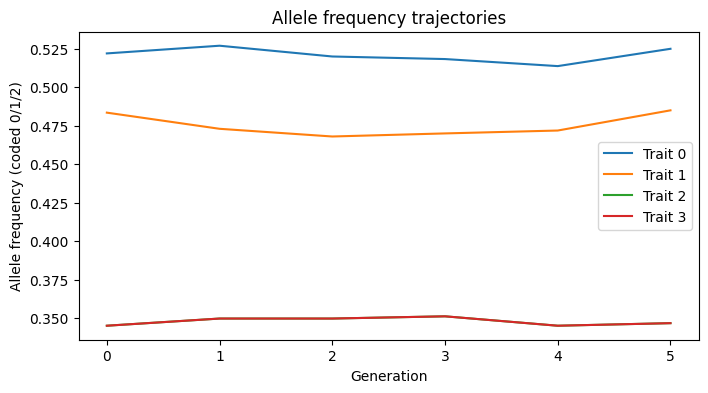

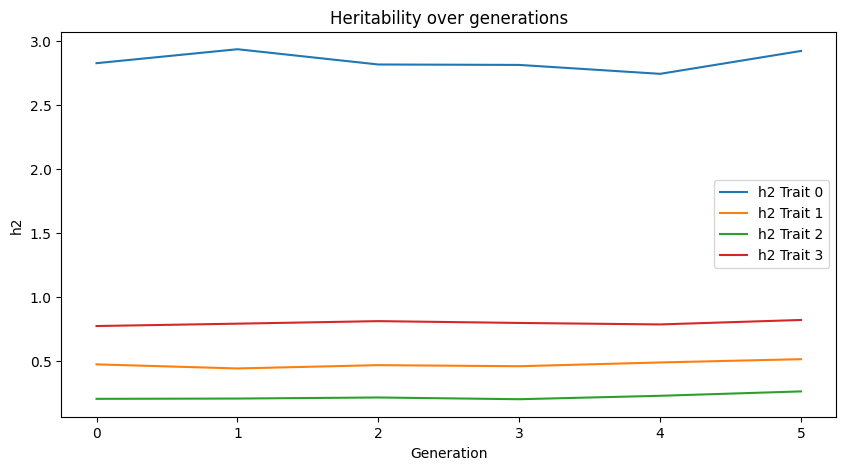

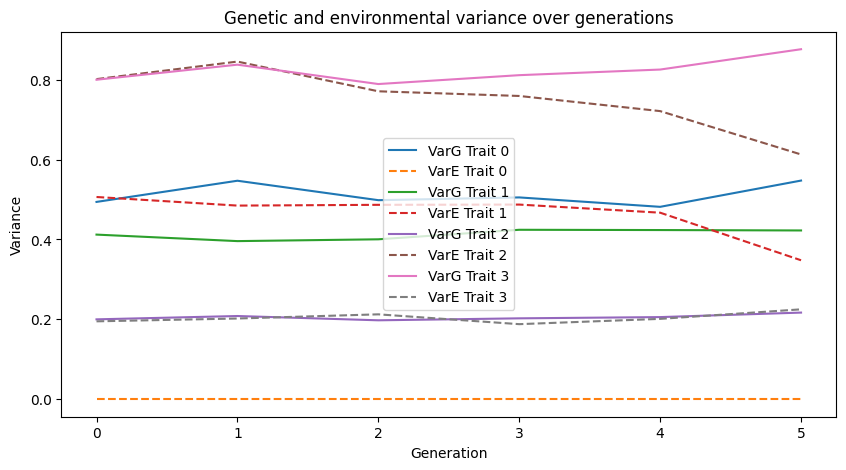

In [437]:
summarize_generations(generations)

### Data for Images

In [ ]:
def compute_trait_stats(trait):
    """Return h2, genetic variance, environmental variance."""
    
    P = np.array(trait.phenotypes, dtype=float)
    E = np.array(trait.environment, dtype=float)

    if trait.type == "monogenic_recessive":
        G_effect = P.copy()
    else:
        G_effect = np.array(trait.genotypes, dtype=float)
    
    var_G = np.var(G_effect)
    var_E = np.var(E)
    var_P = np.var(P)

    h2 = var_G / var_P if var_P > 0 else 0.0

    return h2, var_G, var_E

def compute_rg_re(trait1, trait2):
    """Return genetic correlation and environmental correlation."""
    G1 = np.array(trait1.genotypes, dtype=float)
    G2 = np.array(trait2.genotypes, dtype=float)
    E1 = np.array(trait1.environment, dtype=float)
    E2 = np.array(trait2.environment, dtype=float)

    # handle zero variance cases
    if np.std(G1) == 0 or np.std(G2) == 0:
        rg = 0.0
    else:
        rg = np.corrcoef(G1, G2)[0,1]

    if np.std(E1) == 0 or np.std(E2) == 0:
        re = 0.0
    else:
        re = np.corrcoef(E1, E2)[0,1]

    return rg, re

def calculate_allele_frequencies(trait):
    """
    Computes allele frequencies for a Trait object where trait.alleles is:
        individuals × SNPs
    and each SNP genotype is coded:
        0 = aa
        1 = Aa
        2 = AA

    Returns:
        A list of dicts: [{ 'A': freqA, 'a': freqa }, ...] for each SNP.
    """

    genotypes = np.array(trait.alleles)  # shape: (n_individuals, n_snps)

    if genotypes.ndim != 2:
        genotypes = np.array([[allele] for allele in trait.alleles])
        if genotypes.ndim != 2:
            raise ValueError("trait.alleles must be a 2D list/array: individuals × SNPs")

    n_individuals, n_snps = genotypes.shape
    results = []

    for snp_i in range(n_snps):
        g = genotypes[:, snp_i]

        # allele counts
        count_A = np.sum(g)            # because 0→0 A, 1→1 A, 2→2 A
        count_a = 2*n_individuals - count_A

        freq_A = count_A / (2*n_individuals)
        freq_a = count_a / (2*n_individuals)

        results.append({"A": freq_A, "a": freq_a})

    return results

def calculate_phenotype_distribution(trait, bins=20):
    ph = np.array(trait.phenotypes)

    return {
        "mean": float(np.mean(ph)),
        "variance": float(np.var(ph)),
        "min": float(np.min(ph)),
        "max": float(np.max(ph)),
        "histogram": np.histogram(ph, bins=bins)
    }
